This notebook compares two simulations: 

`i.e21.IHIST.f09_g17.CMIP6-land-hist.001_renormSMB`
* with `glc_renormalize_smb = 'on'` 

`i.e21.IHIST.f09_g17.CMIP6-land-hist.001_NOrenormSMB`
* with `glc_renormalize_smb = "on_if_glc_coupled_fluxes"` (the CESM2 default)

Both of which were cloned from `/gpfs/fs1/work/cmip6/cases/LS3MIP/i.e21.IHIST.f09_g17.CMIP6-land-hist.001` (For some reason SMB in the years under consideration (1850 and 1851) are different from that reference simulation. Not sure why. But this is deemed not important as long as the two simulations themselves have equal QICE values.)

In [1]:
import numpy as np
import math
import sys,os
import xarray as xr

from netCDF4 import Dataset, default_fillvals
from datetime import datetime

import matplotlib.pyplot as plt

# General definitions

In [2]:
# some constants
rhoi= 0.917e3 # kg/m3
rhow= 1.000e3

fac_Gt = 1e-12  # kg
fac_km2 = 1e6   # m

sec_in_year = 365 * 86400.

dpm = np.asarray(( 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)) # days per month


# CLM definitions

Read some static fields that are used for reconstructing the **GrIS** extent and area. 

In [3]:
filename = "/glade/u/home/lvank/work/projects/reconcile_smb/b.e21.BHIST.f09_g17.CMIP6-historical.001_normF.clm2.h0.1850-01-01-00000.nc"
#filename = "/gpfs/fs1/work/lvank/masks/cesm2_fv1/b.e21.BHIST.f09_g17.CMIP6-historical.001_LvK.clm2.h0.1850-01-01-00000.nc"

with xr.open_dataset(filename) as ds:
    imf = ds['ICE_MODEL_FRACTION'][0,:,:].load()
    plu = ds['PCT_LANDUNIT'][0,3,:,:].load()
    lf = ds['landfrac']
    area = ds['area']

The GrIS is defined as the product of ICE_MODEL_FRACTION and PCT_LANDUNIT(4) and has the following area

1810972.0


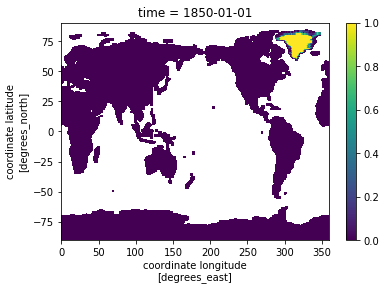

In [4]:
cmask_gis = imf * plu * 0.01 
mma = cmask_gis * area # mma = mask multiplied by area
print(mma.sum().item())
cmask_gis.plot()

Alternatively, we could take the minimum of ICE_MODEL_FRACTION and CLM `landfrac` to come up with a slightly smaller GrIS extent:

1798698.75


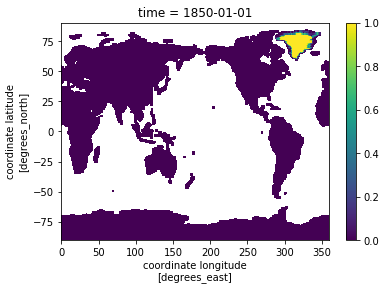

In [5]:
min_lf = xr.where(lf<imf, lf, imf)
cmask_gis2 = min_lf * plu * 0.01 
mma2 = cmask_gis2 * area # mma = mask multiplied by area
print(mma2.sum().item())
cmask_gis2.plot()

# CISM definitions

Using coupler output from a decicated run in which we set `do_histinit = .true.` in the coupler namelist. This generated an extra initial coupler history file. http://www.cesm.ucar.edu/models/cesm2/settings/current/drv_nml.html

In [6]:
#   g2x_nx = 416 ;
#   g2x_ny = 704 ;
#   double g2x_Sg_icemask(time, g2x_ny, g2x_nx) ;
#   double g2x_Sg_icemask_coupled_fluxes(time, g2x_ny, g2x_nx) ;

filename = "/glade/u/home/lvank/work/projects/reconcile_smb/b.e21.BHIST.f09_g17.CMIP6-historical.001_normF.cpl.hi.1850-01-01-00000.nc"

with xr.open_dataset(filename) as ds:

    #foo = ds.g2x_Sg_icemask_coupled_fluxes[0]
    #bar = ds.g2x_Sg_icemask[0]
    ic = ds.g2x_Sg_ice_covered[0]
    
    # Cell area from model
    glc_area1 = ds.domg_area.squeeze()
    lnd_area1 = ds.doml_area.squeeze()
    
    # cell area from mapping file
    glc_area2 = ds.domg_aream.squeeze()
    lnd_area2 = ds.doml_aream.squeeze()


ic.shape, glc_area1.shape, glc_area2.shape

((704, 416), (704, 416), (704, 416))

Where `ic` is the field `Sg_ice_covered` which reflects which grid cells are considered "ice" by CISM. These are the grid cells that we will want to integrated SMB over.

The areas fields (`glc_area1`, `glc_area2`) are given in units of radians, which for the sake of integration we will convert to km^2:

In [8]:
def area_rad_to_km(area_rad):
    """
    convert area in rad^2 to km^2
    """
    r_earth = 6.37122e3 # SHR_CONST_REARTH, in km 
    circ = 2*np.pi*r_earth

    foo = xr.ufuncs.sqrt(area_rad.copy())
    foo *= r_earth
    area_km = foo**2
    return area_km

In [9]:
glc_area_km1 = area_rad_to_km(glc_area1)
glc_area_km2 = area_rad_to_km(glc_area2)

#glc_area_km1.plot()
#glc_area_km1[10,10].item()
np.unique(glc_area_km1.values)

array([16.])

which is to show that on the cartesian / stereographic CISM grid, all grid cell areas are exactly 16 km^2. The coupler knows about the real areas, however:

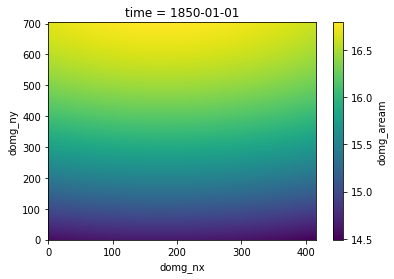

In [16]:
glc_area_km2.plot()

When calculating the GrIS extent using these 2 definitions of area will inevitably lead to differences in total GrIS extent:

In [10]:
print("GrIS extent w/ constant cell area of 16.0 km2 ", ic.sum().item() * 16.)
print("GrIS extent w/ CPL model area", (ic.values * glc_area_km1.values).sum().item() )
print("GrIS extent w/ CPL mapping area", (ic.values * glc_area_km2.values).sum().item() )

GrIS extent w/ constant cell area of 16.0 km2  1805616.0
GrIS extent w/ CPL model area 1805616.0
GrIS extent w/ CPL mapping area 1812254.1880229723


In the remainder, use the last definition (CPL mapping area)

In [28]:
#mma_cism = ic.values * glc_area_km1.values
mma_cism = ic.values * glc_area_km2.values

# Simulation _without_ renormalization

In [38]:
archive = '/glade/scratch/lvank/archive/avg2/'
casename = "i.e21.IHIST.f09_g17.CMIP6-land-hist.001_NOrenormSMB"
period = '1850-1851'

#archive = "/glade/work/lvank/projects/reconcile_smb/archive/"
filename = os.path.join(archive,casename,period,'QICE_i.e21.IHIST.f09_g17.CMIP6-land-hist.001_NOrenormSMB_moncat.nc')
filename2 = os.path.join(archive,casename,period,'smb_i.e21.IHIST.f09_g17.CMIP6-land-hist.001_NOrenormSMB_yearcat.nc')

In [39]:
with xr.open_dataset(filename) as ds:
    qice = ds['QICE'] # monthly means

with xr.open_dataset(filename2) as ds:
    smb = ds['smb'] # annual means

qice.shape, smb.shape

((24, 192, 288), (2, 704, 416))

In [40]:
fac = fac_Gt * fac_km2 # mm/yr w.e. to Gt / yr

for iyear in (0,1):
    
    # select subset of monthly means and compute annual mean
    qice0 = qice[0 + iyear*12 : 12 + iyear*12]    
    assert(len(qice0) == 12)
    
    # convert monthly CLM smb to yearly value
    qice_mean = (qice0 * dpm[:,np.newaxis,np.newaxis]).sum(dim='time') / 365.
    
    # convert mm/s to mm/year
    qice_mean *= sec_in_year
    
    # CLM integrated SMB with "large" GrIS
    clm_smb  = (qice_mean * mma).sum(dim=('lon','lat')).values * fac
    print(1850+iyear, 'CLM smb', clm_smb, 'large')
    
    # CLM integrated SMB with "small" GrIS
    clm_smb  = (qice_mean * mma2).sum(dim=('lon','lat')).values * fac
    print(1850+iyear, 'CLM smb', clm_smb, 'small')
    
    # CISM integrated SMB using coupler area
    tmp = smb[iyear] * fac_Gt * fac_km2 # mm/yr w.e. to Gt / yr
    cism_smb = (tmp.values * mma_cism).sum()
    
    print(1850+iyear, 'CISM smb ', cism_smb)  

1850 CLM smb 1013.3969148718523 large
1850 CLM smb 1012.1460625635658 small
1850 CISM smb  979.3526428022166
1851 CLM smb 663.1682908269477 large
1851 CLM smb 662.485376574198 small
1851 CISM smb  629.9370631299994


# Simulation _with_ renormalization

In [41]:
archive = '/glade/scratch/lvank/archive/avg2/'
casename = "i.e21.IHIST.f09_g17.CMIP6-land-hist.001_renormSMB"
period = '1850-1851'

#archive = "/glade/work/lvank/projects/reconcile_smb/archive/"
filename = os.path.join(archive,casename,period,'QICE_i.e21.IHIST.f09_g17.CMIP6-land-hist.001_renormSMB_moncat.nc')
filename2 = os.path.join(archive,casename,period,'smb_i.e21.IHIST.f09_g17.CMIP6-land-hist.001_renormSMB_yearcat.nc')

In [42]:
with xr.open_dataset(filename) as ds:
    qice = ds['QICE'] # monthly means

with xr.open_dataset(filename2) as ds:
    smb = ds['smb'] # annual means

qice.shape, smb.shape

((24, 192, 288), (2, 704, 416))

In [43]:
fac = fac_Gt * fac_km2 # mm/yr w.e. to Gt / yr

for iyear in (0,1):
    
    # select subset of monthly means and compute annual mean
    qice0 = qice[0 + iyear*12 : 12 + iyear*12]    
    assert(len(qice0) == 12)
    
    # convert monthly CLM smb to yearly value
    qice_mean = (qice0 * dpm[:,np.newaxis,np.newaxis]).sum(dim='time') / 365.
    
    # convert mm/s to mm/year
    qice_mean *= sec_in_year
    
    # CLM integrated SMB with "large" GrIS
    clm_smb  = (qice_mean * mma).sum(dim=('lon','lat')).values * fac
    print(1850+iyear, 'CLM smb', clm_smb, 'large')
    
    # CLM integrated SMB with "small" GrIS
    clm_smb  = (qice_mean * mma2).sum(dim=('lon','lat')).values * fac
    print(1850+iyear, 'CLM smb', clm_smb, 'small')
    
    # CISM integrated SMB using coupler area
    tmp = smb[iyear] * fac_Gt * fac_km2 # mm/yr w.e. to Gt / yr
    cism_smb = (tmp.values * mma_cism).sum()
    
    print(1850+iyear, 'CISM smb ', cism_smb)  

1850 CLM smb 1013.3969148718523 large
1850 CLM smb 1012.1460625635658 small
1850 CISM smb  1000.6164615369281
1851 CLM smb 663.1682908269477 large
1851 CLM smb 662.485376574198 small
1851 CISM smb  654.5674125662342
